In [ ]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
% matplotlib inline 

In [ ]:
df_traffic_data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df_traffic_data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
#copying data to new data frame
df_traffic_features = df_traffic_data.copy()

In [ ]:
#Extracting features from date_time variable
df_traffic_features['date_time'] = pd.to_datetime(df_traffic_features.date_time)
df_traffic_features['weekday'] = df_traffic_features.date_time.dt.weekday
df_traffic_features['date'] = df_traffic_features.date_time.dt.date
df_traffic_features['hour'] = df_traffic_features.date_time.dt.hour
df_traffic_features['month'] = df_traffic_features.date_time.dt.month
df_traffic_features['year'] = df_traffic_features.date_time.dt.year
#Monday is 0 and Sunday is 6

In [ ]:
#13:00:00	4918	1	2012-10-02	13	10	2012
#categorizing hours to different time periods like morning, afternoon etc
def hour_modify(x):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [24,1,2,3]
    if x in Early_Morning:
        return 'Early_Morning'
    elif x in Morning:
        return 'Morning'
    elif x in Afternoon:
        return 'Afternoon'
    elif x in Evening:
        return 'Evening'
    elif x in Night:
        return 'Night'
    else:
        return 'Late_Night'
    
df_traffic_features['hour'] = df_traffic_features.hour.map(hour_modify)

In [ ]:
#Other holidays are very sparse compared to none holidays. 
#Hence encoding the holidays as TRUE and none Holidays as FALSE

def modify_holiday(x):
    if x == 'None':
        return False
    else:
        return True
df_traffic_features['holiday'] = df_traffic_features['holiday'].map(modify_holiday)

In [ ]:
#Outlier in temp which was detected earlier needs to be removed
df_traffic_features = df_traffic_features.loc[df_traffic_features.temp>-250]

In [ ]:
df_traffic_features['weather_description'] = df_traffic_features['weather_description'].map(lambda x:x.lower())

In [ ]:
#Any row containing "thunderstorm" is replaced by "thunderstorm"
df_traffic_features.loc[df_traffic_features['weather_description'].str.contains('thunderstorm'),'weather_description'] = 'thunderstorm'  

In [ ]:
weather = ['thunderstorm','mist','fog','haze']
df_traffic_features.loc[np.logical_not(df_traffic_features['weather_description'].isin(weather)),'weather_description'] = 'other'

In [ ]:
#creating dummy variables for these newly created categories in weather description
df_traffic_features = pd.get_dummies(columns=['weather_description'],data=df_traffic_features)

In [ ]:
df_traffic_features.rename(columns={'weather_description_fog':'fog', 'weather_description_haze':'haze',
                                   'weather_description_mist':'mist', 'weather_description_thunderstorm':'thunderstorm'}, inplace = True)
df_traffic_features.drop(columns = ['weather_description_other', 'weather_main'], inplace = True)

In [ ]:
#Removing outlier in rain column and converting numeric data to categories
#rain value equal to 0.0 as no_rain
#rain value greater than 0.0 is cut into 3 quantiles

df_traffic_features = df_traffic_features.loc[df_traffic_features.rain_1h<2000]
df_traffic_features_temp = df_traffic_features.loc[df_traffic_features.rain_1h>0]
rain_q = pd.DataFrame(pd.qcut(df_traffic_features_temp['rain_1h'] ,q=3, labels=['light','moderate','heavy']))
df_traffic_cat = df_traffic_features.merge(rain_q,left_index=True, right_index=True, how='left')
df_traffic_cat['rain_1h_y'] = df_traffic_cat.rain_1h_y.cat.add_categories('no_rain')
df_traffic_cat['rain_1h_y'].fillna('no_rain', inplace = True) #no_rain is not in the category, adding it and filling

df_traffic_cat.drop(columns=['rain_1h_x'], inplace = True)
df_traffic_cat.rename(columns={'rain_1h_y':'rain_1h'}, inplace = True)

In [ ]:
def modify_snow1h(x):
    if x==0:
        return 'no_snow'
    else:
        return 'snow'
    
df_traffic_features['snow_1h'] = df_traffic_cat.snow_1h.map(modify_snow1h)

In [ ]:
#setting date as index
df_traffic_cat.set_index('date', inplace = True)

In [ ]:
cat_vars = ['holiday', 'snow_1h','weekday', 'hour', 'month', 'year', 'fog', 'haze','mist', 'thunderstorm', 'rain_1h']
num_vars = ['temp','clouds_all','traffic_volume']

In [ ]:
#Creating pipeline to transform data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('oneHot',OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

df_traffic_transformed = preprocessor.fit_transform(df_traffic_cat).toarray()

In [ ]:
# apply PCA to choose best two component
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_traffic_transformed)

In [ ]:
PCA_components = pd.DataFrame(principalComponents)

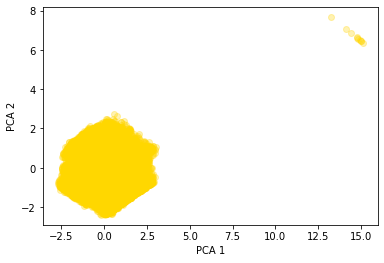

In [ ]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

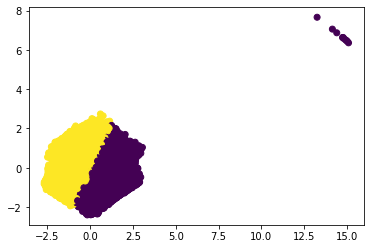

In [ ]:
# apply Kmeans with two cluster
model = KMeans(n_clusters=2)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()